In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt                        
%matplotlib inline 

import cv2
from glob import glob

## About Data
We have train data and test data of images.
* Images are about plant seedlings at various stages of grown.
* Each image has a filename that is its unique id. 
* The dataset comprises 12 plant species. 

The list of species is as follows:
- Black-grass = WEED
- Charlock = PLANT
- Cleavers = WEED
- Common Chickweed = WEED
- Common wheat = PLANT
- Fat Hen = WEED
- Loose Silky-bent = PLANT
- Maize = PLANT
- Scentless Mayweed = WEED 
- Shepherds Purse = WEED
- Small-flowered Cranesbill = WEED
- Sugar beet = PLANT

### Train data loading & labeling

In [4]:

images_path = '/kaggle/input/plant-seedlings-classification/train/*/*.png'
images = glob(images_path) #to return all file paths that match a specific pattern

train_images = []
train_labels = []

for img in images:
    train_images.append(cv2.resize(cv2.imread(img), (256, 256))) #image is 256x256x3
    train_labels.append(img.split('/')[-2])
    
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

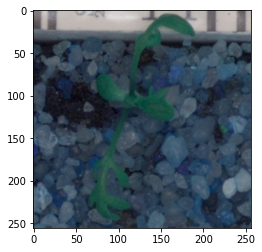

In [5]:
plt.imshow(train_X[1])

In [6]:
train_Y.sample(5)

,0
3688,Fat Hen
3277,Common Chickweed
1006,Charlock
1198,Black-grass
4199,Small-flowered Cranesbill


In [7]:
train_Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [8]:
train_Y.rename(columns={0:'species'},inplace=True)

In [9]:
train_Y.species.unique()

array(['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass',
       'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers',
       'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill',
       'Shepherds Purse'], dtype=object)

In [10]:
plants_type = {
    'Scentless Mayweed': 1, 
    'Common wheat': 0, 
    'Charlock': 0, 
    'Black-grass': 1,
    'Sugar beet': 0, 
    'Loose Silky-bent': 0, 
    'Maize': 0, 
    'Cleavers': 1,
    'Common Chickweed': 1, 
    'Fat Hen': 1, 
    'Small-flowered Cranesbill': 1,
    'Shepherds Purse': 1
}

In [11]:
plants_type['Fat Hen']

1

[Text(0, 0, 'Scentless Mayweed'),
 Text(1, 0, 'Common wheat'),
 Text(2, 0, 'Charlock'),
 Text(3, 0, 'Black-grass'),
 Text(4, 0, 'Sugar beet'),
 Text(5, 0, 'Loose Silky-bent'),
 Text(6, 0, 'Maize'),
 Text(7, 0, 'Cleavers'),
 Text(8, 0, 'Common Chickweed'),
 Text(9, 0, 'Fat Hen'),
 Text(10, 0, 'Small-flowered Cranesbill'),
 Text(11, 0, 'Shepherds Purse')]

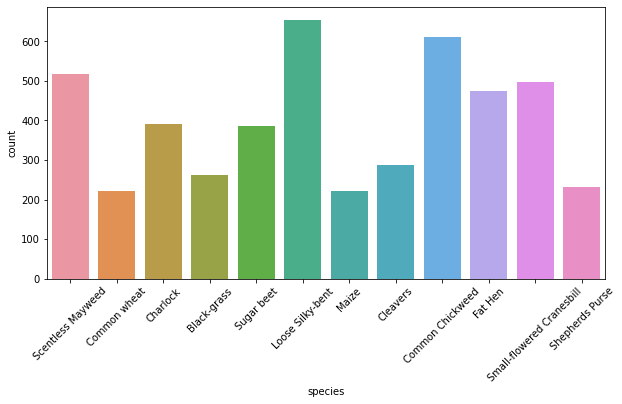

In [12]:
plt.figure(figsize=(10,5))

chart = sns.countplot(
    data=train_Y,
    x='species'
)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [13]:
train_X.shape #4750 images, width,height: 256, RGB color

(4750, 256, 256, 3)

In [14]:
train_Y['species'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: species, dtype: int64

### LabelEncoding Target

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
le.fit(train_Y['species'])
encoded_labels = le.transform(train_Y['species'])
train_label = np_utils.to_categorical(encoded_labels) #Data type: Number to Binary

In [16]:
encoded_labels

array([8, 8, 8, ..., 9, 9, 9])

In [17]:
train_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [18]:
#seed fixing
import random
import os
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

### Train Data & Validation Data 
I used stratify option to solve class imbalance problem.
This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array.

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, 
                                                 train_label, 
                                                 test_size=0.2,
                                                 random_state=seed, 
                                                 stratify=train_label)

In [20]:
# Normalization of the Image Data (for grey scaling)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

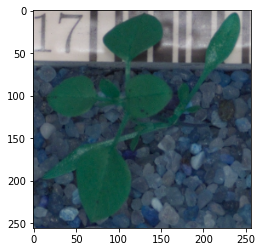

In [21]:
plt.imshow(X_train[1])

### ImageDataGenerator = Data Augmentation


In [22]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

### Build Model

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(256, 256, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.summary()

2022-06-07 17:56:03.290934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 17:56:03.512430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 17:56:03.513293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 17:56:03.522634: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 128)     2

[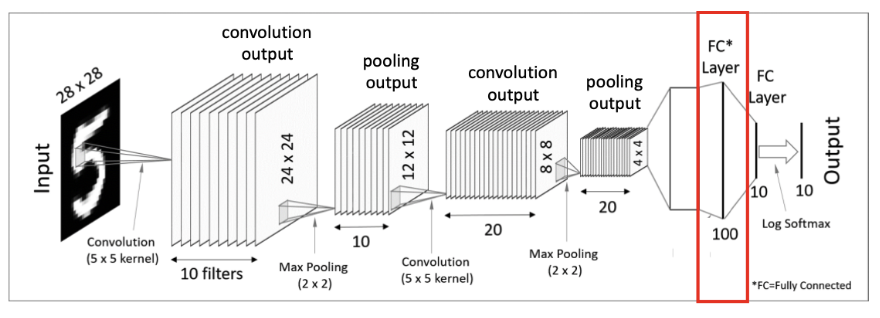](http://)

In [24]:
#Specify Loss and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#where to save the model
model_checkpoint = ModelCheckpoint('/kaggle/working/plantspecies_CNN_model.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

#Stop fitting if there's no enhancement of accuracy for 10 times.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

### Fit Model

In [26]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=8), 
                    epochs=30, validation_data=(X_test, y_test),   
                    callbacks = [early_stopping, model_checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-06-07 17:58:03.884344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-06-07 17:58:06.174235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


475/475 [==============================] - ETA: 0s - loss: 2.9459 - accuracy: 0.1916

2022-06-07 17:59:23.670681: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 747110400 exceeds 10% of free system memory.
2022-06-07 17:59:24.437215: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 747110400 exceeds 10% of free system memory.


475/475 [==============================] - 88s 164ms/step - loss: 2.9459 - accuracy: 0.1916 - val_loss: 1.9588 - val_accuracy: 0.3526

Epoch 00001: val_accuracy improved from -inf to 0.35263, saving model to /kaggle/working/plantspecies_CNN_model.h5
Epoch 2/30
475/475 [==============================] - 72s 151ms/step - loss: 2.2204 - accuracy: 0.2937 - val_loss: 1.7416 - val_accuracy: 0.4179

Epoch 00002: val_accuracy improved from 0.35263 to 0.41789, saving model to /kaggle/working/plantspecies_CNN_model.h5
Epoch 3/30
475/475 [==============================] - 71s 148ms/step - loss: 2.0566 - accuracy: 0.3213 - val_loss: 7.8551 - val_accuracy: 0.1105

Epoch 00003: val_accuracy did not improve from 0.41789
Epoch 4/30
475/475 [==============================] - 72s 152ms/step - loss: 1.7942 - accuracy: 0.3963 - val_loss: 1.6545 - val_accuracy: 0.4695

Epoch 00004: val_accuracy improved from 0.41789 to 0.46947, saving model to /kaggle/working/plantspecies_CNN_model.h5
Epoch 5/30
475/475 [=

### Prediction

In [80]:
predictions = model.predict(X_test)

In [86]:
# Confidences of each class!
predictions[0]

array([9.8519808e-07, 1.7688520e-06, 2.8128261e-07, 3.5287392e-06,
       8.7480061e-05, 4.7693876e-04, 5.0437671e-07, 9.9925476e-01,
       2.3578596e-07, 6.5762634e-08, 1.3455754e-04, 3.8939175e-05],
      dtype=float32)

In [87]:
# Predicted label
np.argmax(predictions[0])

7

In [88]:
pred_class = np.argmax(predictions, axis=1)
actual_class = np.argmax(y_test, axis=1)

pred_str = le.classes_[pred_class]
actual_str = le.classes_[actual_class]

final_pred = {
    'actual': actual_str, 
    'predicted': pred_str
}

final_pred = pd.DataFrame(final_pred)

In [89]:
final_pred.sample(10)

,actual,predicted
798,Fat Hen,Fat Hen
543,Shepherds Purse,Shepherds Purse
754,Maize,Maize
291,Scentless Mayweed,Scentless Mayweed
357,Small-flowered Cranesbill,Small-flowered Cranesbill
709,Fat Hen,Fat Hen
947,Shepherds Purse,Shepherds Purse
183,Small-flowered Cranesbill,Small-flowered Cranesbill
576,Loose Silky-bent,Loose Silky-bent
318,Fat Hen,Fat Hen


## Evaluate the model

In [90]:
#Final score and accuracy of the model
score, acc = model.evaluate(X_test, y_test)

30/30 [==============================] - 2s 66ms/step - loss: 0.7111 - accuracy: 0.7568


In [91]:
print('Validation score:', score,'\nValidation accuracy:', acc)

Validation score: 0.7110856175422668 
Validation accuracy: 0.7568420767784119


In [125]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report: \n')
print(classification_report(
    y_true = actual_class, 
    y_pred = pred_class,
    output_dict=False,
    target_names=le.classes_))

Classification Report: 

                           precision    recall  f1-score   support

              Black-grass       0.25      0.02      0.04        53
                 Charlock       0.93      0.83      0.88        78
                 Cleavers       0.95      0.62      0.75        58
         Common Chickweed       0.82      0.85      0.84       122
             Common wheat       0.36      0.91      0.51        44
                  Fat Hen       0.87      0.92      0.89        95
         Loose Silky-bent       0.79      0.74      0.76       131
                    Maize       0.43      1.00      0.60        44
        Scentless Mayweed       0.94      0.76      0.84       103
          Shepherds Purse       0.82      0.61      0.70        46
Small-flowered Cranesbill       0.85      0.92      0.88        99
               Sugar beet       0.96      0.62      0.76        77

                 accuracy                           0.76       950
                macro avg       0.7

In [123]:
import itertools

# Inspired from scikit-learn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

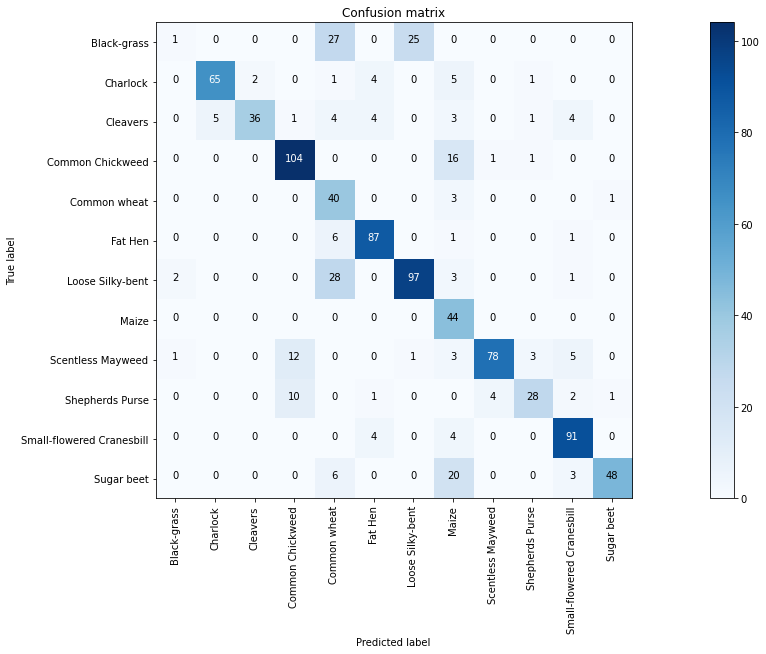

In [124]:
plt.subplots(figsize=(22,9)) #set the size of the plot 

cmatrix = confusion_matrix(actual_class, pred_class)
plot_confusion_matrix(cmatrix, classes = le.classes_)